In [2]:
%env TF_CPP_MIN_LOG_LEVEL=1

import sentence_transformers
import torch
import warnings

warnings.filterwarnings('ignore')

if not torch.cuda.is_available():
    raise Exception('Could not find a CUDA/ROCm-compatible GPU')

model = 'intfloat/e5-base-v2'
model = sentence_transformers.SentenceTransformer(model, device='cuda', model_kwargs={"torch_dtype": "float16"})

env: TF_CPP_MIN_LOG_LEVEL=1


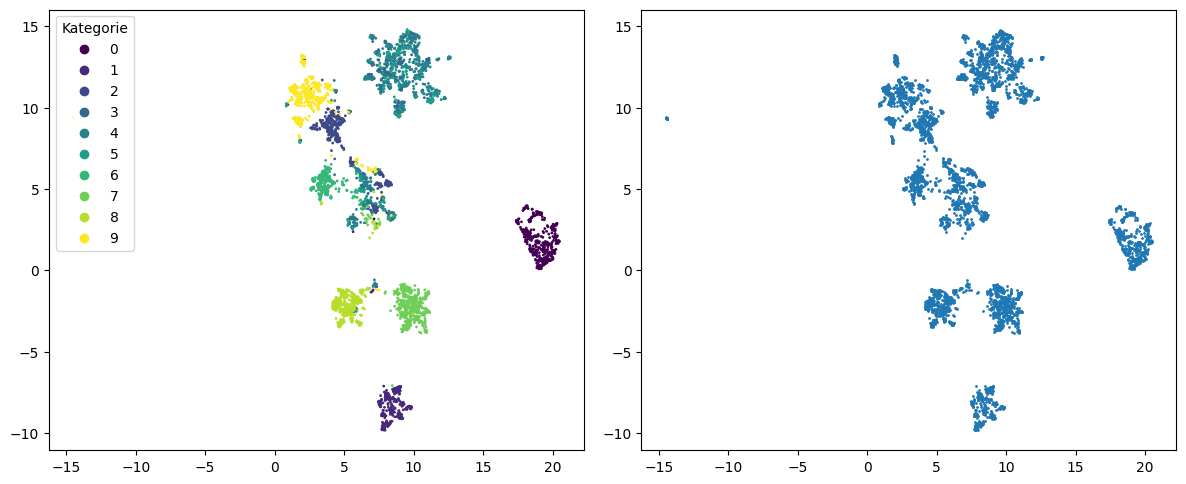

,Product Title,Category Label
18945,beko din28q20 13 place fully integrated dishwa...,Dishwashers
19612,siemens geschirrsp ler extraklasse speedmatic ...,Dishwashers
5876,lg 55sj850v uhd 4k tv 55,TVs
3242,zte blade a612 gold,Mobile Phones
9535,intel xeon e7 8890v4 2.2 ghz 24 core 48 thread...,CPUs
...,...,...
602,gsm mobiltelefon dorophonesecur580s/w 380360,Mobile Phones
7211,samsung ue65nu8509 led tv 163 cm 65 eec a dvb ...,TVs
23377,montpellier mw5100p graded 1000 spin washer,Washing Machines
1147,grade b apple iphone 6 space grey 16gb unlocke...,Mobile Phones


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
count,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,...,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000
mean,-0.027039,-0.021851,-0.012993,-0.001792,0.049133,-0.018158,0.027222,0.030609,-0.025726,-0.010902,...,0.048065,-0.041779,0.040192,-0.035004,0.047180,0.002001,-0.035431,0.001365,0.027649,0.019806
std,0.018829,0.017075,0.017410,0.015373,0.016449,0.015747,0.019089,0.019150,0.016846,0.016327,...,0.017654,0.016281,0.015930,0.014618,0.016373,0.016968,0.017288,0.016449,0.015480,0.015976
min,-0.098938,-0.080750,-0.073486,-0.055481,-0.030365,-0.068787,-0.040619,-0.050964,-0.084900,-0.069641,...,-0.012817,-0.099915,-0.006985,-0.088074,-0.008026,-0.054230,-0.096558,-0.069763,-0.023636,-0.048370
25%,-0.039223,-0.033203,-0.025063,-0.012217,0.038177,-0.029068,0.014717,0.017590,-0.037086,-0.021713,...,0.037170,-0.052956,0.029297,-0.044586,0.035431,-0.009987,-0.046761,-0.009172,0.017132,0.009178
50%,-0.026520,-0.021408,-0.013847,-0.002082,0.048737,-0.019005,0.027863,0.029686,-0.026398,-0.010303,...,0.049316,-0.041138,0.039459,-0.034576,0.046692,0.002138,-0.036011,0.001609,0.027748,0.020134
75%,-0.014271,-0.010265,-0.001750,0.008732,0.059814,-0.008223,0.040810,0.043304,-0.014801,0.000070,...,0.060211,-0.030533,0.050110,-0.025188,0.058167,0.014032,-0.024212,0.012461,0.038216,0.030903
max,0.039978,0.029617,0.050873,0.054230,0.106079,0.043884,0.087402,0.101135,0.032684,0.042328,...,0.103882,0.009750,0.094727,0.014206,0.108643,0.053253,0.036163,0.054138,0.083679,0.080872


,0,1
count,4096.000000,4096.000000
mean,8.176497,4.785260
std,4.846698,6.644495
min,-14.495412,-9.815506
25%,4.805489,-1.411860
50%,7.936562,5.192604
75%,9.791908,10.983193
max,20.495729,14.787892


In [3]:
from pandas import DataFrame, read_csv
from umap import UMAP
from sklearn.preprocessing import LabelEncoder
from matplotlib.pyplot import show, subplots

columns = [
    'Product Title',
    'Category Label'
]

random_state = 401

data = read_csv('pricerunner_aggregate.csv', usecols=columns)
data = data.sample(4096, random_state=random_state)

embeddings = model.encode(data['Product Title'].to_numpy().flatten(), random_state=random_state)
embeddings = DataFrame(embeddings)

projection = UMAP(n_neighbors=20, min_dist=0.3, random_state=random_state).fit_transform(embeddings)
projection = DataFrame(projection)

categories = LabelEncoder().fit_transform(data['Category Label'])
categories = DataFrame(categories)

figure, axes = subplots(1, 2)
figure.set_size_inches(12, 5)
figure.tight_layout()

plot = axes[0].scatter(x=projection[0], y=projection[1], c=categories, label=categories, s=1)
axes[0].legend(*plot.legend_elements(), loc="upper left", title="Kategorie")
axes[1].scatter(x=projection[0], y=projection[1], s=1)
show()

display(data)
display(embeddings.describe())
display(projection.describe())

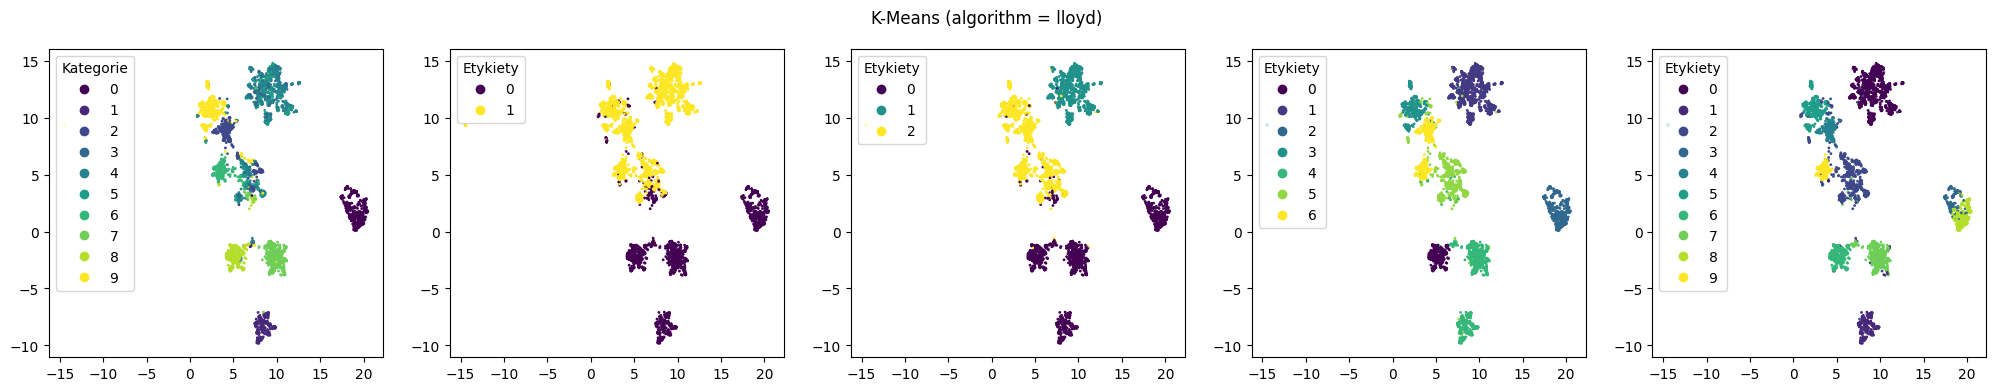

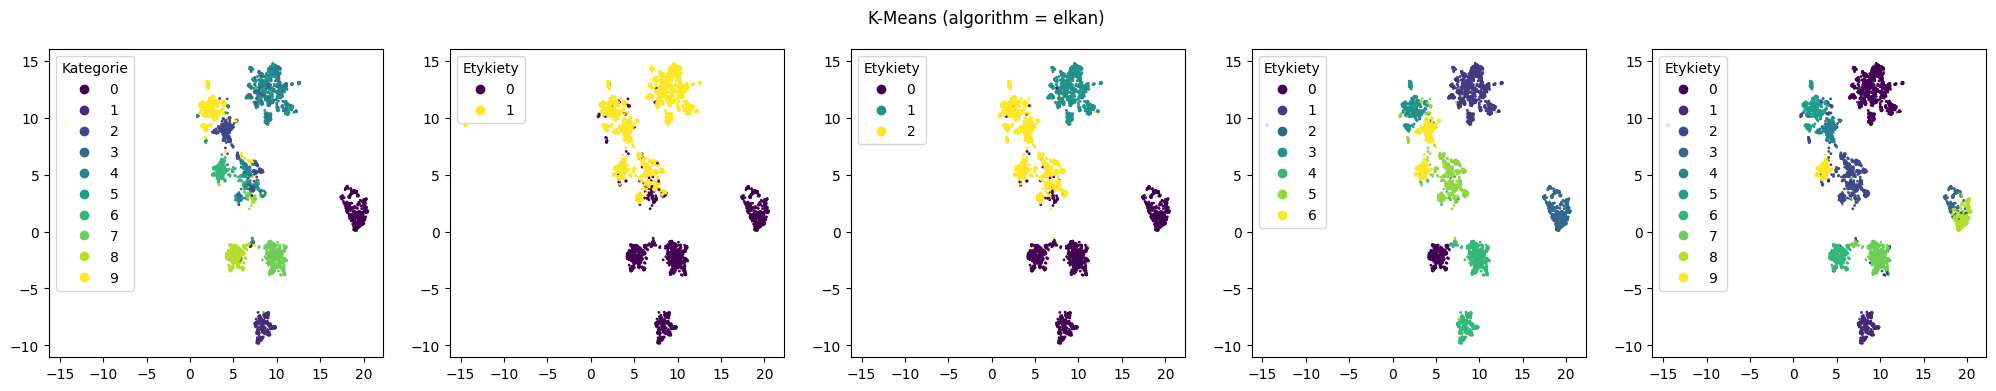

In [4]:
from sklearn.cluster import KMeans

for algorithm in ['lloyd', 'elkan']:
    figure, axes = subplots(1, 5)
    figure.set_size_inches(25, 4)
    figure.suptitle(f'K-Means (algorithm = {algorithm})')

    plot = axes[0].scatter(x=projection[0], y=projection[1], c=categories, label=categories, s=1)
    axes[0].legend(*plot.legend_elements(), loc="upper left", title="Kategorie")

    for index, n_clusters in enumerate([2, 3, 7, 10]):
        cluster = KMeans(n_clusters=n_clusters, n_init=7, algorithm=algorithm, random_state=random_state)
        cluster_labels = cluster.fit_predict(embeddings)
        plot = axes[index + 1].scatter(x=projection[0], y=projection[1], c=cluster_labels, s=1)
        axes[index + 1].legend(*plot.legend_elements(), loc="upper left", title="Etykiety")

show()